In [1]:
###################################################################
# Machine Learning - Binary Classifier
# model 1 / v.2
# Amazon reviews - predict whether a review is going to be helpful
##################################################################

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import string
from scipy.sparse import csr_matrix, hstack
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from IPython.display import display, HTML


get_ipython().magic('matplotlib inline')
from IPython.display import display, HTML

In [2]:
# read the data
data = pd.read_csv('../Amazon.csv')
data.shape
data.head(5)


,Unnamed: 0,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,helpScore,helpful
0,138806,138807,B000E63LME,A1CQGW1AOD0LF2,"Alena K. ""Alena""",1,2,2,1294185600,Not as pictured.,I was looking forward to try cranberry apple f...,0.5,False
1,469680,469681,B004ZIH4KM,A37S7U1OX2MCWI,Becky Cole,0,0,5,1349740800,seeds,"TY for everything. The seeds arrived quickly,...",NaN,False
2,238202,238203,B003ZXE9QA,A2OM6G73E64EQ9,jeff,0,0,5,1329264000,I'm addicted!,I've finally found the best cereal in the worl...,NaN,False
3,485307,485308,B001RVFERK,A25W349EE97NBK,Tangent4,1,1,4,1248307200,I wanted to love these...,I originally bought these chips because I'd he...,1.0,False
4,375283,375284,B000OQZNTS,A3CPPW0HUC07YS,Amy Nicolai,0,0,5,1333238400,Excellent chamomile tea,"Really excellent tea, flowers are visible in t...",NaN,False


In [4]:
##################################################################
# Features extraction
##################################################################

def textProcessor(reviewText):
    '''Takes as an argument the text of the reviews
       Performs a series of transformations
       Returns Pandas dataframe with ten new features
    '''

    # count number of words in review
    nWords = [len(w.split()) for w in reviewText]

    # count number of characters in review
    nChar = [len(c) for c in reviewText]

    # words to characters ratio
    wordCharRatio = [ w/c for w,c in zip( map(float, nWords), map(float, nChar) ) ]

    # number of uppercase words
    nUpper =  [ np.sum( [w.isupper() for w in word.split()] ) for word in reviewText ]

    # uppercase to word ratio
    upperRatio = np.array(nUpper) / np.array(nWords, dtype=float)

    # longest word
    exclude = string.punctuation
    words = [ word.split() for word in reviewText ]
    noPunct = [ [''.join(k for k in c if k not in exclude) for c in w ] for w in words]
    longestWord = [ np.max( [len(w) for w in word] ) for word in noPunct ]

    # average word length
    avgWordLen = [ np.mean( [len(w) for w in word.split()] ) for word in reviewText ]

    # punctuation count
    punctCount = [ np.sum([c.count(p) for p in string.punctuation]) for c in reviewText ]

    # punctuation ratio to character ration
    punctRatio = [ p/c for p,c in zip( map(float, punctCount), map(float, nChar) ) ]

    # exclamation point count
    exclamationPoint = [e.count("!") for e in reviewText]

    names = np.array([ 'nWords', 'nChar', 'wordCharRatio', 'nUpper', 'upperRatio', 'longestWord', 'avgWordLen', 'exclamationPoint', 'punctCount', 'punctRatio' ])
    result = np.array([ nWords, nChar, wordCharRatio, nUpper, upperRatio, longestWord, avgWordLen, exclamationPoint, punctCount, punctRatio ]).T

    myFeatures = pd.DataFrame( result, columns = names )
    # print(myFeatures)
    # print(myFeatures.shape)
    # display(myFeatures)

    return myFeatures

In [5]:
def featuresExtract(data):
    '''Takes as an argument the original dataframe
       Extracts number of unique users and products
       as well as number of repeat users and product to user ratio
       Returns Pandas dataframe with ten new features
    '''

    # how many reviews for the same product in test set - products with more reviews may have more helpful comments as they are more popular
    nReviewsProducts = data.groupby(['ProductId'])['Id'].transform('count')

    # ratio of n reviews to product
    nReviewsRatio = 1 / data.groupby(['ProductId'])['UserId'].transform('count')

    # n repeat users - hypothesis is that people who comment more may provide more helpful reviews
    nRepeatUsers = data.groupby(['UserId'])['ProductId'].transform('count')

    # n unique users
    nUniqueUsers = data.groupby(['ProductId'])['UserId'].transform('count')

    names = np.array([ 'nReviewsProducts', 'nReviewsRatio', 'nRepeatUsers', 'nUniqueUsers' ])
    result = np.array([ nReviewsProducts, nReviewsRatio, nRepeatUsers, nUniqueUsers ]).T
    myFeatures = pd.DataFrame( result, columns = names )


    return myFeatures

In [6]:
# performance measures from Aaron
# these are here to double check my math
def print_results():
    print('Error rate on training set: ')
    print((y_train != y_pred).sum() / X_train.shape[0])
    print('Accuracy rate on training set: ') # train label does not match predicted label / n of instances in train
    print(1 - (y_train != y_pred).sum() / X_train.shape[0])
    print('True positive rate on training tet:') # train label matches predicted label
    print(((y_train==True) & (y_pred==True)).sum() / y_train.sum())
    print('**************')
    print('Error rate on test set: ')
    print((y_test != y_pred_test).sum() / X_test.shape[0])
    print('Accuracy rate on test set: ')
    print(1 - (y_test != y_pred_test).sum() / X_test.shape[0])
    print('True positive rate on test set')
    print(((y_test==True) & (y_pred_test==True)).sum() / y_test.sum())

In [7]:
##################################################################
# Performance measures
##################################################################

class Classification():
    '''Init class with the x,y and y_pred for test and train
       runOn takes a tain_set or test_set as argument and
       draws the appopriate confusion matrix and ROC plot
       as well as outputs the measures for the model.
    '''
    # for binary classification
    # yT = y_train or y_test
    # yP = y_pred or y_pred_test

    def __init__(self, y_train, y_test, y_pred, y_pred_test, runOn='train_set', title="Evaluation of train set"):
        self.y_train = y_train
        self.y_test = y_test
        self.y_pred = y_pred
        self.y_pred_test = y_pred_test
        self.runOn = runOn
        self.title = title
        self.nDashes = 25
        self.df = pd.DataFrame()

    def nPositives(self, yT, yP):
            m = (yT==True).sum();
            self.df = self.df.append({'key': 'nPos',
                                      'metric': 'Number of positives',
                                      'result': m}, ignore_index=True)
    def nNegatives(self, yT, yP):
            m = (yT==False).sum();
            self.df = self.df.append({'key': 'nNeg',
                                      'metric': 'Number of negatives',
                                      'result': m}, ignore_index=True)
    def truePositives(self, yT, yP):
            m =  ((yT==True) & (yP==True)).sum() / len(yT)
            self.df = self.df.append({'key': 'tPos',
                                      'metric': 'True positive rate',
                                      'result': m}, ignore_index=True)

    def trueNegatives(self, yT, yP):
            m = ((yT==False) & (yP==False)).sum() / len(yT)
            self.df = self.df.append({'key': 'tNeg',
                                      'metric': 'True negative rate',
                                      'result': m}, ignore_index=True)

    def falsePositives(self, yT, yP):
            m = (((yT==False) & (yP==True)).sum()) / len(yT)
            self.df = self.df.append({'key': 'fPos',
                                      'metric': 'False positive rate',
                                      'result': m}, ignore_index=True)

    def falseNegatives(self, yT, yP):
            m = (((yT==True) & (yP==False)).sum()) / len(yT)
            self.df = self.df.append({'key': 'fNeg',
                                      'metric': 'False negative rate',
                                      'result': m}, ignore_index=True)

    def propPositives(self, yT, yP):
            m = ((yT==True).sum() / len(yT))
            self.df = self.df.append({'key': 'propPos',
                                      'metric': 'Proportion of positives',
                                      'result': m}, ignore_index=True)

    def propNegatives(self, yT, yP):
            m = (1 - ((yT==True).sum() / len(yT)))
            self.df = self.df.append({'key': 'propNeg',
                                      'metric': 'Proportion of negatives',
                                      'result': m}, ignore_index=True)

    def classRatio(self, yT, yP):
            m = (yT==True).sum() / ( len(yT) - (yT==True).sum() )
            self.df = self.df.append({'key': 'classRatio',
                                      'metric': 'Class Ratio',
                                      'result': m}, ignore_index=True)

    def accuracy(self, yT, yP):
            m = accuracy_score(yT, yP)
            self.df = self.df.append({'key': 'accuracy',
                                      'metric': 'Accuracy',
                                      'result': m}, ignore_index=True)
    def recall(self, yT, yP):
            m = recall_score(yT, yP)
            self.df = self.df.append({'key': 'recall',
                                      'metric': 'Recall',
                                      'result': m}, ignore_index=True)

    def precision(self, yT, yP):
            m = precision_score(yT, yP)
            self.df = self.df.append({'key': 'precision',
                                      'metric': 'Precision',
                                      'result': m}, ignore_index=True)

    def evaluate_model(self, yT, yP):
        # Print classification report in addition
        print('----'*self.nDashes)
        print('Classification report')
        print(classification_report(yT, yP))
        print('----'*self.nDashes)

    def displayMeasures(self):
        if (self.runOn == 'train_set'):
            self.nPositives(self.y_train, self.y_pred)
            self.nNegatives(self.y_train, self.y_pred)
            self.truePositives(self.y_train, self.y_pred)
            self.trueNegatives(self.y_train, self.y_pred)
            self.falsePositives(self.y_train, self.y_pred)
            self.falseNegatives(self.y_train, self.y_pred)
            self.propPositives(self.y_train, self.y_pred)
            self.propNegatives(self.y_train, self.y_pred)
            self.classRatio(self.y_train, self.y_pred)
            self.accuracy(self.y_train, self.y_pred)
            self.precision(self.y_train, self.y_pred)
            self.recall(self.y_train, self.y_pred)
            self.evaluate_model(self.y_train, self.y_pred)
        else:
            self.nPositives(self.y_test, self.y_pred_test)
            self.nNegatives(self.y_test, self.y_pred_test)
            self.truePositives(self.y_test, self.y_pred_test)
            self.trueNegatives(self.y_test, self.y_pred_test)
            self.falsePositives(self.y_test, self.y_pred_test)
            self.falseNegatives(self.y_test, self.y_pred_test)
            self.propPositives(self.y_test, self.y_pred_test)
            self.propNegatives(self.y_test, self.y_pred_test)
            self.classRatio(self.y_test, self.y_pred_test)
            self.accuracy(self.y_test, self.y_pred_test)
            self.precision(self.y_test, self.y_pred_test)
            self.recall(self.y_test, self.y_pred_test)
            self.evaluate_model(self.y_test, self.y_pred_test)

        print('----'*self.nDashes)
        print(self.title)
        print('----'*self.nDashes)
        display(self.df)

    def displayConfusionMatrix(self):
        nClasses = 2
        classNames = ['Unhelpful', 'Helpful']
        if( self.runOn == 'train_set' ):
            # Compute confusion matrix
            cm = confusion_matrix(self.y_train, self.y_pred)
            # Normalize confusion matrix
            ncm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        else:
            # Compute confusion matrix
            cm = confusion_matrix(self.y_test, self.y_pred_test)
            # Normalize confusion matrix
            ncm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        def display(cm, title, sbplot):
            plt.figure(figsize=(20,10))
            plt.subplot(sbplot)
            plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
            plt.title(title)
            plt.colorbar()
            tickMarks = np.arange( nClasses )
            plt.xticks(tickMarks, classNames, rotation=45)
            plt.yticks(tickMarks, classNames)
            plt.ylabel('True Label')
            plt.xlabel('Predicted Label')
            plt.tight_layout()
            # annotate plot
            width, height = cm.shape
            for x in range(width):
                for y in range(height):
                    plt.annotate(str(cm[x][y]), xy=(y, x),
                                horizontalalignment='center',
                                verticalalignment='center',
                                color='red')
            plt.show()


        # call display for both matrices
        np.set_printoptions(precision=2)
        print('----'*self.nDashes)
        print( self.title )
        print('----'*self.nDashes)
        display(cm=cm, title='Confusion matrix', sbplot=211)
        display(cm=ncm, title='Normalized Confusion matrix', sbplot=212)

    def printConfusionMatrix(self):
        if ( self.runOn == 'train_set' ):
            print('----'*self.nDashes)
            cm = pd.crosstab(self.y_train, self.y_pred, rownames=['Actual'], colnames=['Predicted'], margins=False)
            ncm = cm / cm.sum(axis=1)
            print('----'*self.nDashes)
            print('Confusion matrix on train set')
            print('----'*self.nDashes)
            display(cm)
            print('----'*self.nDashes)
            print('Normalized Confusion matrix on train set')
            print('----'*self.nDashes)
            display(ncm)
            print('----'*self.nDashes)
        else:
            print('----'*self.nDashes)
            cm = pd.crosstab(self.y_test, self.y_pred_test, rownames=['Actual'], colnames=['Predicted'], margins=True)
            #cm = confusion_matrix(self.y_test, self.y_pred_test)
            ncm = cm / cm.sum(axis=1)
            print('----'*self.nDashes)
            print('Confusion matrix on test set')
            print('----'*self.nDashes)
            display(cm)
            print('----'*self.nDashes)
            print('Normalized Confusion matrix on test set')
            print('----'*self.nDashes)
            display(ncm)
            # print('----'*self.nDashes)


In [16]:
# ROC plot
def rocPlot(yT, probs):
    '''Takes y for train or test and probabilities'''
    false_positive_rate, true_positive_rate, thresholds = roc_curve(yT, probs)
    roc_auc = auc(false_positive_rate, true_positive_rate)

    ######### PLOT ROC CURVE
    plt.figure()
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.2]) # 0.0, 1.0
    plt.ylim([-0.1,1.2]) # 0.0, 1.0
    plt.ylabel('True Positive Rate (Recall)')
    plt.xlabel('False Positive Rate (Fall-out)')
    plt.show()

In [8]:
##################################################################
# Bag of words
##################################################################
count = HashingVectorizer(n_features=2 ** 17, non_negative=True)
reviewFeatures = count.transform(data.Text)
reviewFeatures.shape


(455000, 131072)

In [9]:
##################################################################
# Call Features extraction functions and convert to sparse matrix
##################################################################

# the text of the features
reviewText = data.Text.as_matrix()

# call features text processor
# NB this one is slow and needs refactoring
myTextFeatures = textProcessor(reviewText)

# call new features extractor
otherFeatures = featuresExtract(data)

# add score and time
scoreAndTime = data[data.columns[7:9]]

# sparse matrix
otherFeaturesSparse = csr_matrix(otherFeatures)
myTextFeaturesSparse = csr_matrix(myTextFeatures)
scoreSparse = csr_matrix(scoreAndTime)

# hstrack features
Xfinal = hstack([reviewFeatures, otherFeaturesSparse, myTextFeaturesSparse,scoreSparse])
X = csr_matrix(Xfinal)
print(type(X))
print(X.shape)

<class 'scipy.sparse.csr.csr_matrix'>
(455000, 131088)


Empty DataFrame
Columns: [nWords, nChar, wordCharRatio, nUpper, upperRatio, longestWord, avgWordLen, exclamationPoint, punctCount, punctRatio]
Index: []
----------------------------------------------------------------------------------------------------
Descriptive stats for nWords
----------------------------------------------------------------------------------------------------
count    455000.000000
mean         80.302782
std          79.484125
min           3.000000
25%          33.000000
50%          56.000000
75%          98.000000
max        3432.000000
Name: nWords, dtype: float64




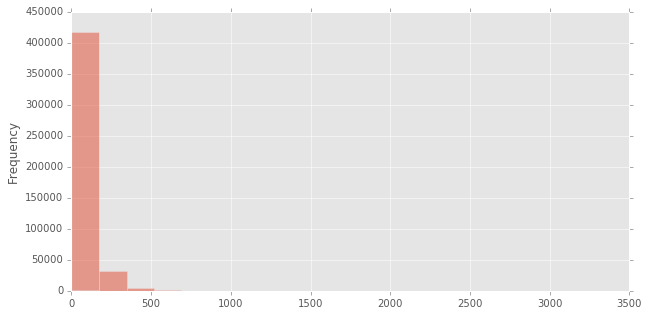

In [10]:
##################################################################
# Utility functions
##################################################################
def viewTags(count, reviewFeatures):
    '''View features from bag of words
        and their respective count. Works only with
        CountVectorizer and TfidfVectorizer
    '''

    # voacabulary
    vocab = count.get_feature_names()

    # Sum up the counts of each vocabulary word
    dist = np.sum(reviewFeatures.toarray(), axis=0)

    # Print unique features
    for tag, count in zip(vocab[1:1000], dist[1:1000]):
        print(count, tag)

# viewTags(count, reviewFeatures)

def show_most_informative_features(vectorizer, clf, n=20):
    '''List the most informative features. I copied this one '''
    '''http://stackoverflow.com/questions/11116697/
    how-to-get-most-informative-features-for-scikit-learn-classifiers'''
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))

# show_most_informative_features(count, lr, n=200)


import matplotlib
matplotlib.style.use('ggplot')

def stats(inSet,feature):
    '''Statistics and distribution for features'''
    # look at descriptive stats and histogram for feature
    # col labels
    print(inSet[1:1])
    # run stats
    plt.figure(figsize=(10,5))
    print('-'*100)
    print('Descriptive stats for %s' % feature)
    print('-'*100)
    print(inSet[feature].describe())
    print('\n')
    inSet[feature].plot(bins=20, kind='hist', alpha=0.5)




stats(myTextFeatures,'nWords')
# uncomment to view distributions
# stats(myTextFeatures,'nChar')
# stats(myTextFeatures,'wordCharRatio')
# stats(myTextFeatures,'nUpper')
# stats(myTextFeatures,'upperRatio')
# stats(myTextFeatures,'longestWord')
# stats(myTextFeatures,'avgWordLen')
# stats(myTextFeatures,'exclamationPoint')
# stats(myTextFeatures,'punctCount')
# stats(myTextFeatures,'punctRatio')

# stats(otherFeatures,'nReviewsProducts')
# stats(otherFeatures,'nReviewsRatio')
# stats(otherFeatures,'nRepeatUsers')
# stats(otherFeatures,'nUniqueUsers')



In [11]:
##################################################################
# Define Y vector
##################################################################
# define y vector --> Extract the values of the Helpful column
y = data.iloc[:, 12].values

In [12]:
##################################################################
# Create training and test sets
##################################################################
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 0)

In [13]:
##################################################################
# Convert to std scalar
##################################################################
sc = StandardScaler(with_mean=False)
sc.fit(X_train) # fit to training set so the scaling is based on training
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)


In [22]:
##################################################################
# Model Logistic Regression
##################################################################

lr = LogisticRegression(class_weight='balanced', n_jobs=-1, penalty='l2', C=7)
y_pred = lr.fit( X_train_std, y_train ).predict( X_train_std )
# Predict class labels for samples in X_test
y_pred_test = lr.predict(X_test_std)
probabilities = lr.predict_proba(X_test_std)[:,1]
probabilities_train = lr.predict_proba(X_train_std)[:,1]




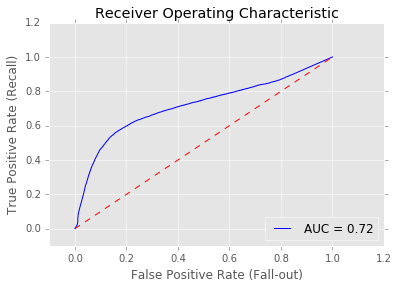

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Confusion matrix on test set
----------------------------------------------------------------------------------------------------


Predicted,False,True,All
Actual,,,
False,107916,18577,126493
True,4552,5455,10007
All,112468,24032,136500


----------------------------------------------------------------------------------------------------
Normalized Confusion matrix on test set
----------------------------------------------------------------------------------------------------


Predicted,False,True,All
Actual,,,
False,0.426569,0.928200,0.463344
True,0.017993,0.272559,0.036656
All,0.444562,1.200759,0.500000


----------------------------------------------------------------------------------------------------
Classification report
             precision    recall  f1-score   support

      False       0.96      0.85      0.90    126493
       True       0.23      0.55      0.32     10007

avg / total       0.91      0.83      0.86    136500

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Evaluation of test set
----------------------------------------------------------------------------------------------------


,key,metric,result
0,nPos,Number of positives,10007.000000
1,nNeg,Number of negatives,126493.000000
2,tPos,True positive rate,0.039963
3,tNeg,True negative rate,0.790593
4,fPos,False positive rate,0.136095
5,fNeg,False negative rate,0.033348
6,propPos,Proportion of positives,0.073311
7,propNeg,Proportion of negatives,0.926689
8,classRatio,Class Ratio,0.079111
9,accuracy,Accuracy,0.830557


----------------------------------------------------------------------------------------------------
Evaluation of test set
----------------------------------------------------------------------------------------------------


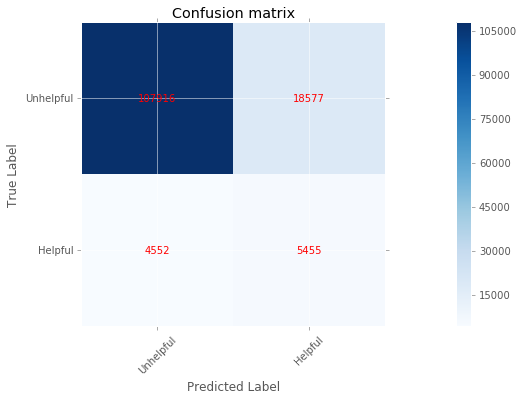

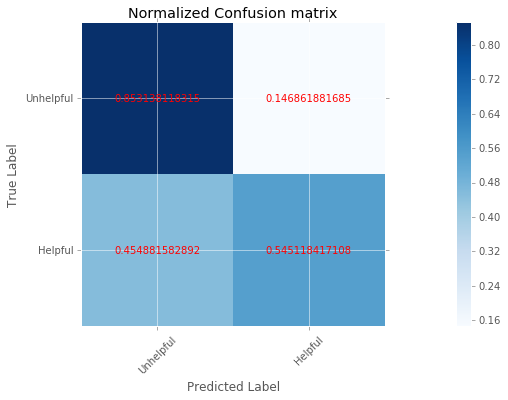

In [23]:
##################################################################
# ROC Plot / Measures report / Confusion Matrix Test Set
##################################################################
rocPlot(y_test, probabilities)

# init measures report
model_LogisticRegression = Classification(y_train, y_test, y_pred, y_pred_test, runOn='test_set', title="Evaluation of test set")
model_LogisticRegression.printConfusionMatrix()
model_LogisticRegression.displayMeasures()

# display confusion matrix
model_LogisticRegression.displayConfusionMatrix()

# Evaluate
# print_results()

# run cross val score
# scores = cross_val_score(clf, X_train, y_train, cv=20)
# print('Cross val scores:')
# print(np.mean(scores), scores)

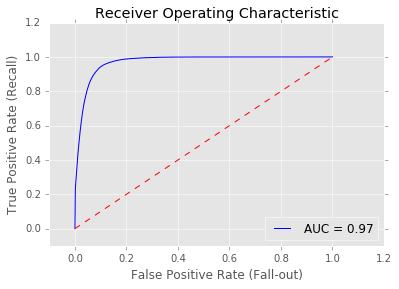

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Confusion matrix on train set
----------------------------------------------------------------------------------------------------


Predicted,False,True
Actual,,
False,265953,29319
True,1340,21888


----------------------------------------------------------------------------------------------------
Normalized Confusion matrix on train set
----------------------------------------------------------------------------------------------------


Predicted,False,True
Actual,,
False,0.900705,1.262227
True,0.004538,0.942311


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Classification report
             precision    recall  f1-score   support

      False       0.99      0.90      0.95    295272
       True       0.43      0.94      0.59     23228

avg / total       0.95      0.90      0.92    318500

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Evaluation of train set
----------------------------------------------------------------------------------------------------


,key,metric,result
0,nPos,Number of positives,23228.000000
1,nNeg,Number of negatives,295272.000000
2,tPos,True positive rate,0.068722
3,tNeg,True negative rate,0.835017
4,fPos,False positive rate,0.092053
5,fNeg,False negative rate,0.004207
6,propPos,Proportion of positives,0.072929
7,propNeg,Proportion of negatives,0.927071
8,classRatio,Class Ratio,0.078666
9,accuracy,Accuracy,0.903739


----------------------------------------------------------------------------------------------------
Evaluation of train set
----------------------------------------------------------------------------------------------------


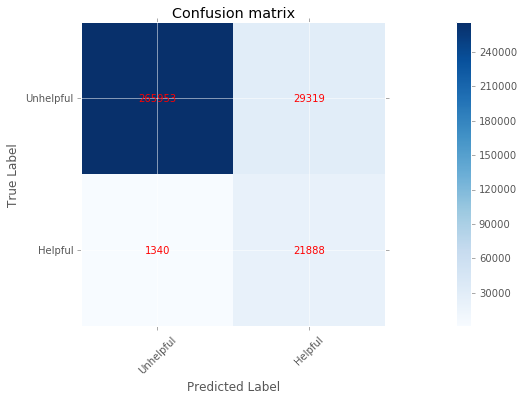

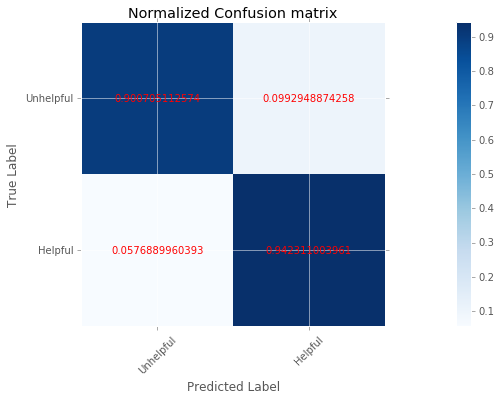

In [24]:
##################################################################
# ROC Plot / Measures report / Confusion Matrix Train Set
##################################################################

rocPlot(y_train, probabilities_train)

# init measures report
model_LogisticRegression = Classification(y_train, y_test, y_pred, y_pred_test, runOn='train_set', title="Evaluation of train set")
model_LogisticRegression.printConfusionMatrix()
model_LogisticRegression.displayMeasures()

# display confusion matrix
model_LogisticRegression.displayConfusionMatrix()

# Evaluate train set
# print_results()

